<a href="https://colab.research.google.com/github/karino2/US-patent-analysis/blob/bert_input/colab/bert_benchmark_2000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BERT on 2000-2000 prediction benchmark trial**

To compare bert with other model, evaluate on our benchmark setting.

Basic code is from here: 
https://github.com/karino2/US-patent-analysis/blob/master/notebook/tfidf_nearest.ipynb

In [0]:
import os
import datetime
import pickle
import gzip

import tensorflow as tf

In [2]:
tf.__version__

'1.12.0'

In [3]:
!git clone -b docker https://github.com/yoheikikuta/bert.git

Cloning into 'bert'...
remote: Enumerating objects: 269, done.
remote: Total 269 (delta 0), reused 0 (delta 0), pack-reused 269
Receiving objects: 100% (269/269), 174.41 KiB | 2.64 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [4]:
!ls

bert  sample_data


# Data setup

Data setup is based on https://github.com/karino2/US-patent-analysis/blob/bert_input/colab/bert_tokenized_claim_setup.ipynb

In [0]:
!mkdir ./bert/data

In [0]:
from google.colab import auth
auth.authenticate_user()

In [8]:
!gsutil cp gs://karino2-uspatent/features/test_grants_ids.pkl.gz ./bert/data/

Copying gs://karino2-uspatent/features/test_grants_ids.pkl.gz...
/ [1 files][  3.0 MiB/  3.0 MiB]                                                
Operation completed over 1 objects/3.0 MiB.                                      


In [9]:
%%time
with gzip.open("./bert/data/test_grants_ids.pkl.gz", 'rb') as f:
     (test_ids, grants_ids) = pickle.load(f)

CPU times: user 343 ms, sys: 163 ms, total: 506 ms
Wall time: 510 ms


**Check tpu name**

In [10]:
import datetime
import json
import os
import pprint
import random
import string
import sys
import tensorflow as tf

assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

from google.colab import auth
auth.authenticate_user()

with tf.Session(TPU_ADDRESS) as session:
  print('TPU devices:')
  pprint.pprint(session.list_devices())

  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

TPU address is grpc://10.15.120.218:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 4298392443942794684),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1923170471964936461),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 6228095721152161989),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6732931291765328744),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 6798991559338036958),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 15873917152675780060),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 199907361241214455),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 5734044260161643251),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 4825598

### Bert setup

In [0]:
VOCAB_CONFIG_PATH=' gs://yohei-kikuta/mlstudy-phys/bert/models/pre-trained-models/uncased_L-12_H-768_A-12' #@param {type:"string"}

In [12]:
!gsutil cp {VOCAB_CONFIG_PATH}/vocab.txt ./bert/model/patent/vocab.txt
!gsutil cp {VOCAB_CONFIG_PATH}/bert_config.json ./bert/model/patent/bert_config.json

Copying gs://yohei-kikuta/mlstudy-phys/bert/models/pre-trained-models/uncased_L-12_H-768_A-12/vocab.txt...
- [1 files][226.1 KiB/226.1 KiB]                                                
Operation completed over 1 objects/226.1 KiB.                                    
Copying gs://yohei-kikuta/mlstudy-phys/bert/models/pre-trained-models/uncased_L-12_H-768_A-12/bert_config.json...
/ [1 files][  313.0 B/  313.0 B]                                                
Operation completed over 1 objects/313.0 B.                                      


In [13]:
!ls ./bert/model/patent

bert_config.json  vocab.txt


In [0]:
import sys
sys.path.append("./bert")

In [0]:
import tokenization

In [0]:
tokenizer = tokenization.FullTokenizer(
    vocab_file="./bert/model/patent/vocab.txt", do_lower_case=True)

In [0]:
CLS_ID = tokenizer.vocab["[CLS]"]
SEP_ID = tokenizer.vocab["[SEP]"]

In [0]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
  """Truncates a sequence pair in place to the maximum length."""

  # This is a simple heuristic which will always truncate the longer sequence
  # one token at a time. This makes more sense than truncating an equal percent
  # of tokens from each, since if one sequence is very short then each token
  # that's truncated likely contains more information than a longer sequence.
  while True:
    total_length = len(tokens_a) + len(tokens_b)
    if total_length <= max_length:
      break
    if len(tokens_a) > len(tokens_b):
      tokens_a.pop()
    else:
      tokens_b.pop()

In [0]:
label_list = ["not_entailment", "entailment"]
max_seq_length = 512

label_map = {}
for (i, label) in enumerate(label_list):
  label_map[label] = i

In [0]:
def original_convert_single_pair(ids_a_input, ids_b_input):

  # Clone and pop for truncate. Most of the case result len is the same for our purpose, but try simple implementation first.
  ids_a = list(ids_a_input)
  ids_b = list(ids_b_input)
    
  # Modifies `tokens_a` and `tokens_b` in place so that the total
  # length is less than the specified length.
  # Account for [CLS], [SEP], [SEP] with "- 3"
  _truncate_seq_pair(ids_a, ids_b, max_seq_length - 3)

  # The convention in BERT is:
  # (a) For sequence pairs:
  #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
  #  type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
  # (b) For single sequences:
  #  tokens:   [CLS] the dog is hairy . [SEP]
  #  type_ids: 0     0   0   0  0     0 0
  #
  # Where "type_ids" are used to indicate whether this is the first
  # sequence or the second sequence. The embedding vectors for `type=0` and
  # `type=1` were learned during pre-training and are added to the wordpiece
  # embedding vector (and position vector). This is not *strictly* necessary
  # since the [SEP] token unambiguously separates the sequences, but it makes
  # it easier for the model to learn the concept of sequences.
  #
  # For classification tasks, the first vector (corresponding to [CLS]) is
  # used as as the "sentence vector". Note that this only makes sense because
  # the entire model is fine-tuned.
  input_ids = []
  segment_ids = []
  input_ids.append(CLS_ID)
  segment_ids.append(0)
  for token in ids_a:
    input_ids.append(token)
    segment_ids.append(0)
  input_ids.append(SEP_ID)
  segment_ids.append(0)

  for token in ids_b:
    input_ids.append(token)
    segment_ids.append(1)
  input_ids.append(SEP_ID)
  segment_ids.append(1)

  # The mask has 1 for real tokens and 0 for padding tokens. Only real
  # tokens are attended to.
  input_mask = [1] * len(input_ids)

  # Zero-pad up to the sequence length.
  while len(input_ids) < max_seq_length:
    input_ids.append(0)
    input_mask.append(0)
    segment_ids.append(0)

  assert len(input_ids) == max_seq_length
  assert len(input_mask) == max_seq_length
  assert len(segment_ids) == max_seq_length

  return (input_ids, input_mask, segment_ids)


### Optimization for our application

dup ids consume huge memory.
We cach and use the same memory if ids_a_nput and ids_b_input have enough size.

In [0]:
NORMAL_INPUT_MASK = [1]*max_seq_length
NORMAL_SEGMENT_IDS = [0]*257+[1]*255

In [0]:
# [CLS](0), 1-255(len=255), [SEP], 257-510(len=254), [SEP]

In [0]:
LEN_255_CACHE = {}
LEN_254_CACHE = {}

In [0]:
def truncage_with_cache(ids, target_len):
  if target_len == 255:
    cache = LEN_255_CACHE
  else:
    assert target_len == 254
    cache = LEN_254_CACHE
  if ids not in cache:
    cache[ids] = ids[0:target_len]
  return cache[ids]

In [0]:
def fast_convert_single_pair(ids_a_input, ids_b_input):  
  if (len(ids_a_input) < 256) or (len(ids_b_input) < 256) :
    return original_convert_single_pair(ids_a_input, ids_b_input)
  
  ids_a = truncage_with_cache(ids_a_input, 255)
  ids_b = truncage_with_cache(ids_b_input, 254)

  input_ids = (CLS_ID,) + ids_a + (SEP_ID,) + ids_b + (SEP_ID,)
  
  return (input_ids, NORMAL_INPUT_MASK, NORMAL_SEGMENT_IDS)


In [0]:
def feature_tuplist_to_feature_dict(ftups):
    dic = {}
    dic['input_ids'] = [tup[0] for tup in ftups]
    dic["input_mask"] = [tup[1] for tup in ftups]
    dic["segment_ids"] = [tup[2] for tup in ftups]
    dic["label_ids"] = [[0] for _ in ftups]
    return dic

List is not hashable, but all element is int and tuple is hashable in this case. We use this ids as key for caching.

In [0]:
test_ids_tup = [tuple(ids) for ids in test_ids]

In [0]:
grants_ids_tup = [tuple(ids) for ids in grants_ids]

In [0]:
pairs = [("{}_{}".format(i, j), app_claim, grants_claim) for i, app_claim in enumerate(test_ids_tup) for j, grants_claim in enumerate(grants_ids_tup)]

In [0]:
import os

import modeling
import tokenization

from run_classifier import model_fn_builder


In [0]:
bert_config = modeling.BertConfig.from_json_file("./bert/model/patent/bert_config.json")

In [32]:
BUCKET = 'karino2-uspatent' #@param {type:"string"}
OUTPUT_DIR = 'gs://{}/mlstudy-phys/bert/models/patent_1000'.format(BUCKET)

INIT_CHECK_POINT_FILE='model.ckpt-1602' #@param {type:"string"}
INIT_CHECK_POINT = '{}/{}'.format(OUTPUT_DIR, INIT_CHECK_POINT_FILE)

tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))
print('***** Init checkpoint: {} *****'.format(INIT_CHECK_POINT))

***** Model output directory: gs://karino2-uspatent/mlstudy-phys/bert/models/patent_1000 *****
***** Init checkpoint: gs://karino2-uspatent/mlstudy-phys/bert/models/patent_1000/model.ckpt-1602 *****


In [0]:
class FLAGS(object):
    '''Parameters.'''
    def __init__(self):
        self.vocab_file = "./bert/model/patent/vocab.txt"
        self.use_tpu = True
        self.output_dir = OUTPUT_DIR
        # self.data_dir = "./bert/data/1000"
        self.init_checkpoint = INIT_CHECK_POINT
        self.predict_batch_size = 16
        # TPU related
        self.num_tpu_cores = 8
        self.tpu_name = TPU_ADDRESS
        
        # following parameters are not used anymore. (because we create feature by hand)
        self.do_lower_case = True
        self.max_seq_length = 512
        
        # The following parameters are not used in predictions.
        # Just use to create RunConfig.
        self.master = None
        self.save_checkpoints_steps = 1
        self.learning_rate = 0
        self.num_warmup_steps = 0
        self.num_train_steps = 0
        # TPU related. Some of these value have positive int not to make TPUEstimator angry (even though these are not used...).
        self.eval_batch_size = 32
        self.train_batch_size = 32 
        self.iterations_per_loop = 1000


In [0]:
FLAGS = FLAGS()

In [0]:
# tokenizer = tokenization.FullTokenizer(
#    vocab_file=FLAGS.vocab_file, do_lower_case=FLAGS.do_lower_case)

# tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu=FLAGS.tpu_name).get_master()
tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu=FLAGS.tpu_name)

is_per_host = tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2

run_config = tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    master=FLAGS.master,
    model_dir=FLAGS.output_dir,
    save_checkpoints_steps=FLAGS.save_checkpoints_steps,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=FLAGS.iterations_per_loop,
        num_shards=FLAGS.num_tpu_cores,
        per_host_input_for_training=is_per_host))

In [0]:
model_fn = model_fn_builder(
    bert_config=bert_config,
    num_labels=len(["not_entailment", "entailment"]),
    init_checkpoint=FLAGS.init_checkpoint,
    learning_rate=FLAGS.learning_rate,
    num_train_steps=FLAGS.num_train_steps,
    num_warmup_steps=FLAGS.num_warmup_steps,
    use_tpu=FLAGS.use_tpu,
    use_one_hot_embeddings=FLAGS.use_tpu)

In [0]:
# https://github.com/kyzhouhzau/BERT-NER/issues/19

def model_fn_wrapper(features, labels, mode, params):
  tspec = model_fn(features, labels, mode, params)
  pred_dict = {'predictions': tspec.predictions}
  return tf.contrib.tpu.TPUEstimatorSpec(
          mode=tspec.mode, predictions=pred_dict, scaffold_fn=tspec.scaffold_fn)


In [38]:
estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=FLAGS.use_tpu,
    # model_fn=model_fn,
    model_fn=model_fn_wrapper,
    config=run_config,
    train_batch_size=FLAGS.train_batch_size,
    eval_batch_size=FLAGS.eval_batch_size,
    predict_batch_size=FLAGS.predict_batch_size)

INFO:tensorflow:Using config: {'_model_dir': 'gs://karino2-uspatent/mlstudy-phys/bert/models/patent_1000', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      value: "10.15.120.218:8470"
    }
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe2d6fd0208>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': b'grpc://10.15.120.218:8470', '_evaluation_master': b'grpc://10.15.120.218:8470', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=8,

### Whole data set is too big for memory

Specify which block we will handle.

In [0]:
# 0 to 4
block_id = 0

In [0]:
%%time
fdict = feature_tuplist_to_feature_dict([fast_convert_single_pair(tup[1], tup[2]) for tup in pairs[(block_id)*252400*2:(block_id+1)*252400*2]])

CPU times: user 44.8 s, sys: 4.28 s, total: 49 s
Wall time: 49.1 s


### 200 app_id seems still too big, resude to 20 app.

In [0]:
len(fdict['input_ids'])

504800

In [0]:
fdict['label_ids'] = [[0]]*len(fdict['input_ids'])

In [0]:
small_fdict = {key: fdict[key][0:50480] for key in fdict.keys()}

In [0]:
len(small_fdict['input_ids'])

50480

In [0]:
small_fdict.keys()

dict_keys(['input_ids', 'input_mask', 'segment_ids', 'label_ids'])

In [0]:
small_fdict['label_ids'][0:5]

[[0], [0], [0], [0], [0]]

In [0]:
# test_fdict = test_fdicts_all
test_fdict = small_fdict

In [0]:
def batch_input_function(params):
    test_ds = tf.data.Dataset.from_tensor_slices(test_fdict)    
    return test_ds.batch(params['batch_size'])

In [0]:
result = estimator.predict(batch_input_function)

In [0]:
print(datetime.datetime.today())

2019-01-08 12:01:40.695459


Below cell takes about 36 min, but output says shorter time (I don't know the reason).


In [0]:
%%time
#It will take about one hour on a CPU environment.

result = list(result)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:*** Features ***
INFO:tensorflow:  name = input_ids, shape = (2, 512)
INFO:tensorflow:  name = input_mask, shape = (2, 512)
INFO:tensorflow:  name = label_ids, shape = (2, 1)
INFO:tensorflow:  name = segment_ids, shape = (2, 512)
INFO:tensorflow:**** Trainable Variables ****
INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (30522, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/bias:0,

In [0]:
print(datetime.datetime.today())

2019-01-08 12:37:49.739961


In [0]:
result_unwrap = [pred['predictions'] for pred in result]

In [0]:
len(result_unwrap)

50480

In [0]:
%%time
with gzip.open("result_0_50480.pkl.gz", 'w') as f:
     pickle.dump(result_unwrap, f)

CPU times: user 1.76 s, sys: 23.1 ms, total: 1.79 s
Wall time: 1.79 s


In [0]:
!gsutil cp result_0_50480.pkl.gz gs://karino2-uspatent/features/

Copying file://result_0_50480.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][  1.0 MiB/  1.0 MiB]                                                
Operation completed over 1 objects/1.0 MiB.                                      


### Result evaluation

First, check the ranking of scores for label patent.

In [39]:
!gsutil cp gs://karino2-uspatent/features/result_0_50480.pkl.gz ./

Copying gs://karino2-uspatent/features/result_0_50480.pkl.gz...
/ [1 files][  1.0 MiB/  1.0 MiB]                                                
Operation completed over 1 objects/1.0 MiB.                                      


In [48]:
!gsutil cp gs://karino2-uspatent/citations_info_2000.df.gz ./bert/data/
!gsutil cp gs://karino2-uspatent/testset_app_1000.df.gz ./bert/data/
!gsutil cp gs://karino2-uspatent/training_app_1000.df.gz ./bert/data/
!gsutil cp gs://karino2-uspatent/grants_for_2000.df.gz ./bert/data/

Copying gs://karino2-uspatent/citations_info_2000.df.gz...
/ [1 files][234.3 KiB/234.3 KiB]                                                
Operation completed over 1 objects/234.3 KiB.                                    
Copying gs://karino2-uspatent/testset_app_1000.df.gz...
/ [1 files][ 13.4 MiB/ 13.4 MiB]                                                
Operation completed over 1 objects/13.4 MiB.                                     
Copying gs://karino2-uspatent/training_app_1000.df.gz...
/ [1 files][ 14.2 MiB/ 14.2 MiB]                                                
Operation completed over 1 objects/14.2 MiB.                                     
Copying gs://karino2-uspatent/grants_for_2000.df.gz...
- [1 files][ 44.6 MiB/ 44.6 MiB]                                                
Operation completed over 1 objects/44.6 MiB.                                     


In [0]:
import gzip
import pickle
with gzip.open("result_0_50480.pkl.gz", 'rb') as f:
     result_unwrap = pickle.load(f)

In [0]:
import pandas as pd
import numpy as np

In [0]:
citations_info_target = pd.read_pickle("./bert/data/citations_info_2000.df.gz")
# training_app_df = pd.read_pickle("./bert/data/training_app_1000.df.gz")
testset_app_df = pd.read_pickle("./bert/data/testset_app_1000.df.gz")
grants_target_df = pd.read_pickle("./bert/data/grants_for_2000.df.gz")

In [0]:
GRANTS_NUM = len(grants_ids)

In [51]:
app_num = len(result_unwrap)/GRANTS_NUM
app_num

20.0

In [0]:
app_num = int(app_num)

In [0]:
app_ids = testset_app_df.app_id[0:app_num]

In [0]:
def cited_ranking(app_idx):

  result_for_one_app = result_unwrap[app_idx*GRANTS_NUM: (app_idx+1)*GRANTS_NUM]
  result_for_one_app_true = [tup[1] for tup in result_for_one_app]
  one_app_id = app_ids[app_idx]
  cited_ids = citations_info_target[citations_info_target.app_id == one_app_id].parsed
  
  def gen_fun():

    for cited_id in cited_ids.values:
      i, = np.where(grants_target_df.parsed.values == cited_id)
      cited_index = i[0]
      ranking = sorted(result_for_one_app_true, reverse=True).index(result_for_one_app_true[cited_index])
      yield (one_app_id, cited_ids.values[0], ranking, result_for_one_app_true[cited_index])
  return list(gen_fun())

In [0]:
all_rank_tuples = [tup for appid in range(20) for tup in cited_ranking(appid)]

In [77]:
all_rank_tuples[0:5]

[(14307191, 7576688, 1189, 0.00013937514),
 (13137006, 6856341, 36, 0.9998958),
 (12741959, 7871985, 8, 0.9999076),
 (12643447, 7101233, 3, 0.9999107),
 (14200253, 8119053, 231, 0.0002699617)]

In [0]:
all_ranks = [tup[2] for tup in all_rank_tuples]

In [80]:
all_ranks[0:5]

[1189, 36, 8, 3, 231]

In [81]:
sorted(all_ranks)[0:10]

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

In [0]:
import matplotlib.pyplot as plt

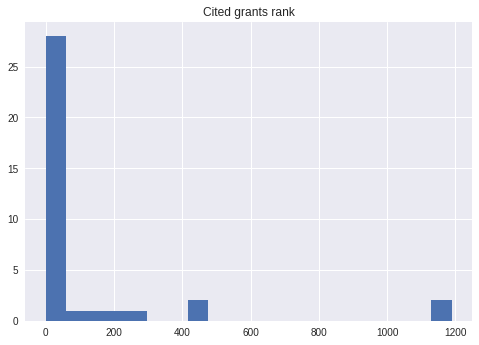

In [72]:
plt.hist(all_ranks, bins=20)
plt.title("Cited grants rank")
plt.show()

In [76]:
pd.DataFrame({"rank": sorted(all_ranks)})

,rank
0,0
1,0
2,0
3,0
4,0
5,1
6,1
7,1
8,1
9,1


# Try and error

Below here is try and error.

In [0]:
app_idx = 0


result_for_one_app = result_unwrap[app_idx*GRANTS_NUM: (app_idx+1)*GRANTS_NUM]

In [0]:
one_app_id = app_ids[app_idx]

In [0]:
one_app_id

14307191

In [0]:
cited_ids = citations_info_target[citations_info_target.app_id == one_app_id].parsed

In [0]:
cited_ids.values[0]

7576688

In [0]:
result_for_one_app[0:5]

[array([9.9987113e-01, 1.2879973e-04], dtype=float32),
 array([9.9987471e-01, 1.2525565e-04], dtype=float32),
 array([9.9986601e-01, 1.3391985e-04], dtype=float32),
 array([9.9987304e-01, 1.2690226e-04], dtype=float32),
 array([9.9986780e-01, 1.3221534e-04], dtype=float32)]

In [0]:
result_for_one_app_true = [tup[1] for tup in result_for_one_app]

In [0]:
grants_target_df.shape

(2524, 2)

In [0]:
i, = np.where(grants_target_df.parsed.values == cited_ids.values[0])
cited_index = i[0]

In [0]:
grants_target_df.parsed.values[cited_index]

7576688

In [0]:
result_for_one_app_true[cited_index:cited_index+3]

[0.00013937514, 0.47318903, 0.00014103286]

In [0]:
grants_target_df.parsed.values[0]

6837383

In [0]:
grants_target_df.parsed.values[0:5]

array([6837383, 6837647, 6837799, 6837893, 6837910])

In [0]:
np.where(grants_target_df.parsed.values == 6837647)

(array([1]),)

In [0]:
sorted(result_for_one_app_true, reverse=True).index(result_for_one_app_true[cited_index])

1189

In [0]:
cited_ranking(0)

[(14307191, 7576688, 1189, 0.00013937514)]

In [0]:
cited_ranking(1)

[(13137006, 6856341, 36, 0.9998958)]

In [0]:
result_unwrap[0:5]

[array([9.9987113e-01, 1.2879973e-04], dtype=float32),
 array([9.9987471e-01, 1.2525565e-04], dtype=float32),
 array([9.9986601e-01, 1.3391985e-04], dtype=float32),
 array([9.9987304e-01, 1.2690226e-04], dtype=float32),
 array([9.9986780e-01, 1.3221534e-04], dtype=float32)]

In [0]:
result_unwrap[0:5]

[array([9.9987113e-01, 1.2879973e-04], dtype=float32),
 array([9.9987471e-01, 1.2525565e-04], dtype=float32),
 array([9.9986601e-01, 1.3391985e-04], dtype=float32),
 array([9.9987304e-01, 1.2690226e-04], dtype=float32),
 array([9.9986780e-01, 1.3221534e-04], dtype=float32)]

Check first app result manually

In [0]:
label_df.head()

,6837383,6837647,6837799,6837893,6837910,6838140,6838207,6838507,6838812,6838925,...,8334161,8334431,8334887,8336128,8336158,8336789,8336964,8337193,8339697,8340894
14307191,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13137006,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12741959,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12643447,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14200253,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [0]:
citations_info_target[citations_info_target["app_id"]==14307191].parsed

698    7576688
Name: parsed, dtype: int64

In [0]:
label_df.columns.get_loc(7576688)

1533

In [0]:
result_unwrap[1530:1535]

[array([9.9984968e-01, 1.5024767e-04], dtype=float32),
 array([9.9986899e-01, 1.3095887e-04], dtype=float32),
 array([9.9981815e-01, 1.8189823e-04], dtype=float32),
 array([9.9986064e-01, 1.3937514e-04], dtype=float32),
 array([0.52681094, 0.47318903], dtype=float32)]

In [0]:
label_df.columns[1533]

7576688

In [0]:
result_unwrap[1530:1535]

[array([9.9984968e-01, 1.5024767e-04], dtype=float32),
 array([9.9986899e-01, 1.3095887e-04], dtype=float32),
 array([9.9981815e-01, 1.8189823e-04], dtype=float32),
 array([9.9986064e-01, 1.3937514e-04], dtype=float32),
 array([0.52681094, 0.47318903], dtype=float32)]

In [0]:
[one["index"] for one in tupples[1530:1535]]

['0_7575179', '0_7575572', '0_7575840', '0_7576688', '0_7577750']

In [0]:
tupples[0]

{'claim_app': '\n \n  1 . A method to aggregate, filter, and share energy data for analysis, the method comprising:\n receiving first data associated with a first electrical circuit, the first data having a first protocol; \n sampling the first data at a first sampling rate to generate first digital data, wherein the first sampling rate is substantially continuous; and \n transmitting reporting digital data over a network having a network protocol different from the first protocol, the reporting digital data comprising at least the first digital data, wherein the reporting digital data is transmitted at a reporting rate that is decoupled from the first sampling rate. \n \n \n \n  2 . The method of  claim 1  further comprising:\n receiving second data associated with a second electrical circuit, the second data having a second protocol different from the first protocol; and \n sampling the second data at a second sampling rate to generate second digital data, wherein the second sampling

In [0]:
label_df.columns[0]

6837383

In [0]:
len(label_df.columns)

2524

In [0]:
first_res = [tup[1] for tup in result_unwrap[0:2524]]

In [0]:
first_res.index(max(first_res))

2429

In [0]:
result_unwrap[2429]

array([9.6167554e-05, 9.9990380e-01], dtype=float32)

In [0]:
sorted(first_res, reverse=True)[0:100]

[0.9999038,
 0.9999002,
 0.9999,
 0.9998981,
 0.9998971,
 0.99989426,
 0.9998926,
 0.9998896,
 0.9998851,
 0.9998845,
 0.9998822,
 0.9998683,
 0.99986625,
 0.99986136,
 0.9998572,
 0.999851,
 0.99984765,
 0.99984276,
 0.99983644,
 0.9998337,
 0.9998331,
 0.99982184,
 0.9998141,
 0.9998128,
 0.99981123,
 0.99979824,
 0.9997905,
 0.99977726,
 0.9997663,
 0.9997607,
 0.99974984,
 0.9997284,
 0.99970305,
 0.99966955,
 0.99966323,
 0.99964607,
 0.99948835,
 0.9994863,
 0.9994686,
 0.9994173,
 0.9993445,
 0.99932206,
 0.9992962,
 0.99916995,
 0.99912757,
 0.99909306,
 0.9990852,
 0.9990293,
 0.9989574,
 0.9989573,
 0.99878114,
 0.9985979,
 0.99844414,
 0.9983937,
 0.9983798,
 0.99776447,
 0.99763006,
 0.99744403,
 0.99735945,
 0.9972683,
 0.99682057,
 0.99669987,
 0.9965874,
 0.9965056,
 0.9963832,
 0.9958139,
 0.9955245,
 0.9948787,
 0.9948294,
 0.9942055,
 0.9940918,
 0.99350864,
 0.9931433,
 0.99291205,
 0.9925493,
 0.9902334,
 0.987956,
 0.98655933,
 0.9856634,
 0.9856187,
 0.9761249,
 0

First application is not so impressive result. Try second one.

In [0]:
one_res = [tup[1] for tup in result_unwrap[2524*1:2524*2]]

In [0]:
citations_info_target[citations_info_target["app_id"]==13137006].parsed

1150    6856341
Name: parsed, dtype: int64

In [0]:
label_df.columns.get_loc(6856341)

43

In [0]:
one_res[43]

0.9998958

In [0]:
one_res.index(max(one_res))

1862

In [0]:
one_res[1862]

0.99990904

In [0]:
sorted(one_res, reverse=True)[0:50]

[0.99990904,
 0.99990845,
 0.9999075,
 0.9999074,
 0.999907,
 0.99990594,
 0.9999052,
 0.999905,
 0.99990475,
 0.9999039,
 0.9999038,
 0.9999032,
 0.9999031,
 0.9999031,
 0.99990296,
 0.9999027,
 0.9999021,
 0.99990153,
 0.9999014,
 0.9999012,
 0.99990106,
 0.99990094,
 0.99990046,
 0.99990034,
 0.9999,
 0.99989974,
 0.99989927,
 0.999899,
 0.9998988,
 0.9998987,
 0.9998982,
 0.99989796,
 0.9998976,
 0.99989736,
 0.9998964,
 0.99989605,
 0.9998958,
 0.999895,
 0.99989486,
 0.9998944,
 0.99989426,
 0.9998933,
 0.9998933,
 0.99989307,
 0.9998926,
 0.9998921,
 0.9998909,
 0.99988914,
 0.9998889,
 0.9998882]

In [0]:
sorted(one_res, reverse=True).index(one_res[43])

36

In [0]:
label_df.columns[43]

6856341

In [0]:
len(one_res)

2524

In [0]:
list(test_fdict.keys())

['input_ids', 'input_mask', 'segment_ids', 'label_ids']

In [0]:
testset_app_df.head()

,app_id,xml
0,14307191,"<us-patent-application lang=""EN"" dtd-version=""..."
1,13137006,"<us-patent-application lang=""EN"" dtd-version=""..."
2,12741959,"<us-patent-application lang=""EN"" dtd-version=""..."
3,12643447,"<us-patent-application lang=""EN"" dtd-version=""..."
4,14200253,"<us-patent-application lang=""EN"" dtd-version=""..."


In [0]:
test_data.head()

,index,claim_app,claim_cited_grant,label
0,0,1 . A rotational angle detection device for a ...,1. A tangible computer-readable medium having ...,not_entailment
1,1,1 . A method comprising:sensing electrocardiog...,"1. A medical system, comprising:an implantable...",entailment
2,2,1 . A system for controlling temperature insid...,1. An integrated differential receiver for an ...,not_entailment
3,3,1 . A recording apparatus for recording update...,1. A method for indicating a priority of a Voi...,not_entailment
4,4,1 . Apparatus for moving a material within an ...,1. A wellbore packer having an expandable pack...,entailment


In [0]:
1000*1000*(43.7/2502)/(60*60)

4.85167421618261

### Below here is obsolete, update to merge to above

# Dataset setup

Download dataframe from cloud storage

### Utility: Retrieve just claim. Remove all tags.

In [0]:
import re

In [0]:
CLAIM_PAT = re.compile(r'<claims[^>]*>(.*)</claims>',re.MULTILINE|re.DOTALL)
TAG_PAT = re.compile(r"<.*?>")

In [0]:
def whole_xml_to_claim_xml(whole):
    mat = CLAIM_PAT.search(whole)
    return mat.group(1)
  
  
def whole_xml_to_claim(whole):
    return TAG_PAT.sub(' ', whole_xml_to_claim_xml(whole))

### Create label data

In [0]:
def set_one_answer_appid(labeldf, oneappid):
    cited_patids = citations_info_target[citations_info_target.app_id == oneappid].parsed
    labeldf.loc[oneappid] = labeldf.columns.isin(cited_patids)
    
    
def create_label_df():
    label_df = pd.DataFrame(columns=grants_target_df.parsed.values, dtype=np.bool)
    for appid in testset_app_df.app_id:
        set_one_answer_appid(label_df, appid)
    return label_df

In [0]:
label_df = create_label_df()
label_df.shape

(1000, 2524)

Confirm label data

In [0]:
label_df.loc[14307191].idxmax()

7576688

In [0]:
citations_info_target[citations_info_target["app_id"]==14307191].parsed

698    7576688
Name: parsed, dtype: int64

# Test set evaluation code

For predcition, we need to preprocess input and it takes some times.
So I split original code to preprocess function and evaluation function

In [0]:
def test_set_preprocess(preprocess_func):
  predictdf = pd.DataFrame(columns=grants_target_df.parsed.values, dtype=np.bool)
   preprocess_func(testset_app_df["xml"].map(whole_xml_to_claim))

In [0]:
testset_app_claims = testset_app_df["xml"].map(whole_xml_to_claim)

In [0]:
testset_app_claims.shape

(1000,)

In [0]:
def predict_test_set(predict_func):
    """
    predict_func(claims) return NxM of boolean. N is len(claims). M is rownum of grants_target_df.
            value indicate n claim is cite patent of m row of grants_all_df.
    """
    predictdf = pd.DataFrame(columns=grants_target_df.parsed.values, dtype=np.bool)
    res = predict_func(testset_app_df["xml"].map(whole_xml_to_claim))
    for idx, appid in enumerate(testset_app_df.app_id):
        predictdf.loc[appid] = res[idx, :]
    return predictdf

In [0]:
def calc_TPs(preddf, labeldf):
    return sum([sum(preddf.loc[one_appid][labeldf.loc[one_appid]]) for one_appid in testset_app_df.app_id])

def calc_FPs(preddf, labeldf):
    return sum([sum(preddf.loc[one_appid][~labeldf.loc[one_appid]]) for one_appid in testset_app_df.app_id])

def calc_TNs(preddf, labeldf):
    return sum([sum(preddf.loc[one_appid][~labeldf.loc[one_appid]] == False) for one_appid in testset_app_df.app_id])

def calc_FNs(preddf, labeldf):
    return sum([sum(preddf.loc[one_appid][labeldf.loc[one_appid]] == False) for one_appid in testset_app_df.app_id])

def calc_TFPNs(preddf, labeldf):
    return calc_TPs(preddf, labeldf), calc_FPs(preddf, labeldf), calc_TNs(preddf, labeldf), calc_FNs(preddf, labeldf)

In [0]:
def calc_summary_TFPNs(TP, FP, TN, FN):
    "return acc, prec, recall, f1."
    return pd.DataFrame(columns=["acc", "prec", "recall", "f1"], data=[[(TP+TN)/(TP+FP+TN+FN), TP/(TP+FP), TP/(TP+FN), 2*TP/(2*TP+FP+FN)]])
    
def calc_summary(preddf, labeldf):
    TP, FP, TN, FN = calc_TFPNs(preddf, labeldf)
    return calc_summary_TFPNs(TP, FP, TN, FN)

### Adjust testset data to bert

On evaluation, we need some pair of
app2017-grants2012 claims.

I try to cerate one-app to all grants2012 pair and tokenize here.
If it takes too long times, I'll write more clever code.



In [0]:
grants_target_df["claim"] = grants_target_df["xml"].map(whole_xml_to_claim)

In [0]:
grants_target_df.head()

,parsed,xml,claim
0,6837383,"<us-patent-grant lang=""EN"" dtd-version=""v40 20...",\n \n 1. A tool organizer for mounting to and ...
1,6837647,"<us-patent-grant lang=""EN"" dtd-version=""v40 20...",\n \n 1. A modular crowd and traffic control b...
2,6837799,"<us-patent-grant lang=""EN"" dtd-version=""v40 20...","\n \n 1. A method of aligning a putter, compri..."
3,6837893,"<us-patent-grant lang=""EN"" dtd-version=""v40 20...",\n \n 1. Apparatus for inserting a surgical fa...
4,6837910,"<us-patent-grant lang=""EN"" dtd-version=""v40 20...",\n \n 1. An apparatus for gasifying a liquid o...


In [0]:
testset_app_claims.shape

(1000,)

In [0]:
small_testset = testset_app_claims[0:10]

In [0]:
small_testset.shape

(10,)

In [0]:
small_testset.index

RangeIndex(start=0, stop=10, step=1)

In [0]:
small_grants = grants_target_df.head()

In [0]:
input_claims = small_testset
candidate_grants = small_grants

In [0]:
input_claims = small_testset
candidate_grants = grants_target_df

In [0]:
tupples = []

for i, claim in enumerate(input_claims):
  tupples.extend([{"index":"{}_{}".format(i, grants.parsed), "claim_app":claim, "claim_cited_grant":grants.claim} for _, grants in candidate_grants.iterrows()])


In [0]:
tupples[0:5]

[{'claim_app': '\n \n  1 . A method to aggregate, filter, and share energy data for analysis, the method comprising:\n receiving first data associated with a first electrical circuit, the first data having a first protocol; \n sampling the first data at a first sampling rate to generate first digital data, wherein the first sampling rate is substantially continuous; and \n transmitting reporting digital data over a network having a network protocol different from the first protocol, the reporting digital data comprising at least the first digital data, wherein the reporting digital data is transmitted at a reporting rate that is decoupled from the first sampling rate. \n \n \n \n  2 . The method of  claim 1  further comprising:\n receiving second data associated with a second electrical circuit, the second data having a second protocol different from the first protocol; and \n sampling the second data at a second sampling rate to generate second digital data, wherein the second samplin

In [0]:
len(tupples)

25240

In [0]:
!gsutil cp -r gs://yohei-kikuta/mlstudy-phys/bert/data/1000 ./bert/data/

Copying gs://yohei-kikuta/mlstudy-phys/bert/data/1000/bert_extracted_feature_test_1000.pkl...
Copying gs://yohei-kikuta/mlstudy-phys/bert/data/1000/bert_extracted_feature_train_1000.pkl...
Copying gs://yohei-kikuta/mlstudy-phys/bert/data/1000/dev.tsv...
Copying gs://yohei-kikuta/mlstudy-phys/bert/data/1000/train.tsv...
- [4 files][154.8 MiB/154.8 MiB]   22.7 MiB/s                                   
Operation completed over 4 objects/154.8 MiB.                                    


In [0]:
test_data = pd.read_csv("./bert/data/1000/dev.tsv", sep="\t")

In [0]:
test_data.head()

,index,claim_app,claim_cited_grant,label
0,0,1 . A rotational angle detection device for a ...,1. A tangible computer-readable medium having ...,not_entailment
1,1,1 . A method comprising:sensing electrocardiog...,"1. A medical system, comprising:an implantable...",entailment
2,2,1 . A system for controlling temperature insid...,1. An integrated differential receiver for an ...,not_entailment
3,3,1 . A recording apparatus for recording update...,1. A method for indicating a priority of a Voi...,not_entailment
4,4,1 . Apparatus for moving a material within an ...,1. A wellbore packer having an expandable pack...,entailment


In [0]:
from run_classifier import convert_single_example
from run_classifier import InputExample
from run_classifier import file_based_input_fn_builder

In [0]:
MAX_SEQ_LEN = 512

In [0]:

def row_to_feature(i, row, max_seq_len=MAX_SEQ_LEN):
    if 'label' in row:
        example = InputExample(
            guid = row['index'],
            text_a = row['claim_app'],
            text_b = row['claim_cited_grant'],
            label = row['label']
            )
    else :
        example = InputExample(
            guid = row['index'],
            text_a = row['claim_app'],
            text_b = row['claim_cited_grant'],
            label="not_entailment"
            )
    
    return convert_single_example(
        ex_index=i, 
        example=example,
        label_list=["not_entailment", "entailment"],
        max_seq_length=max_seq_len,
        tokenizer=tokenizer)

In [0]:
def feature_list_to_feature_dict(flist):
    dic = {}
    dic['input_ids'] = [feature.input_ids for feature in flist]
    dic["input_mask"] = [feature.input_mask for feature in flist]
    dic["segment_ids"] = [feature.segment_ids for feature in flist]
    dic["label_ids"] = [[feature.label_id] for feature in flist]
    return dic

In [0]:
def tupples_to_fdicts(tups):
    features = [row_to_feature(i, row) for i, row in enumerate(tups)]
    return feature_list_to_feature_dict(features)

In [0]:
%%time
test_fdicts_all = tupples_to_fdicts(tupples)

INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: 0_6837383
INFO:tensorflow:tokens: [CLS] 1 . a method to aggregate , filter , and share energy data for analysis , the method comprising : receiving first data associated with a first electrical circuit , the first data having a first protocol ; sampling the first data at a first sampling rate to generate first digital data , wherein the first sampling rate is substantially continuous ; and transmitting reporting digital data over a network having a network protocol different from the first protocol , the reporting digital data comprising at least the first digital data , wherein the reporting digital data is transmitted at a reporting rate that is deco ##up ##led from the first sampling rate . 2 . the method of claim 1 further comprising : receiving second data associated with a second electrical circuit , the second data having a second protocol different from the first protocol ; and sampling the second data at a second sampling r

In [0]:
%%time

test_fdict_all = df_to_fdicts(test_data)

INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: 0
INFO:tensorflow:tokens: [CLS] 1 . a rotational angle detection device for a permanent magnet dynamo - electric machine comprising : a stat ##or that includes arm ##at ##ure winding ; a rotor that includes a rotor core and a plurality of permanent magnet ##s ; and a conduct ##ive circuit that includes first conductors extending in an axial direction of the rotor and being disposed in at least two places in a ci ##rc ##um ##fer ##ential direction of the rotor , and second conductors for electrically inter ##con ##ne ##cting the first conductors , wherein , the first conductors are each disposed within one of a range of an electrical angle between & # x ##22 ##12 ; 45 & # x ##b ##0 ; and + 45 & # x ##b ##0 ; in the ci ##rc ##um ##fer ##ential direction with a magnetic pole center of each of the plurality of permanent magnet ##s being set as a reference and a range of an electrical angle between & # x ##22 ##12 ; 45 & # x ##b ##0 ; an

In [0]:
import pickle

In [0]:
with open('test_fdict_all.pkl', 'wb') as f:
     pickle.dump(test_fdicts_all, f)

In [0]:
with open('test_fdict_all.pkl', 'rb') as f:
    test_fdict_all = pickle.load(f)